# A regression problem with 3 solutions

Regression predictive modeling is the task of approximating a mapping function (f) from input variables (X) to a continuous output variable (y). In the following we can see 3 approaches to solve the same task, first by gradient descent, then by a small hand coded neural net, and finally, analytically. But first let us get acquainted with the dataset.

In [23]:
import numpy as np

pwd = %pwd
raw_data = np.genfromtxt( pwd + '\\Data\\ex1data2.txt', delimiter=',')

The file ex1data2.txt contains a training set of housing prices in Portland, Oregon. The first column is the size of the house (in square feet), the second column is the number of bedrooms, and the third column is the price of the house. Our task is, to fit a model that correctly predicts the price of a new house based on its size and number of bedrooms.

In [24]:
ones = np.ones((len(raw_data), 1))
X = raw_data[:, 0:2].astype(np.float64)
y = np.array(raw_data[:, 2]).reshape(len(raw_data), 1).astype(np.float64)

Which on a 3D plot looks as follows:

<IPython.core.display.Javascript object>


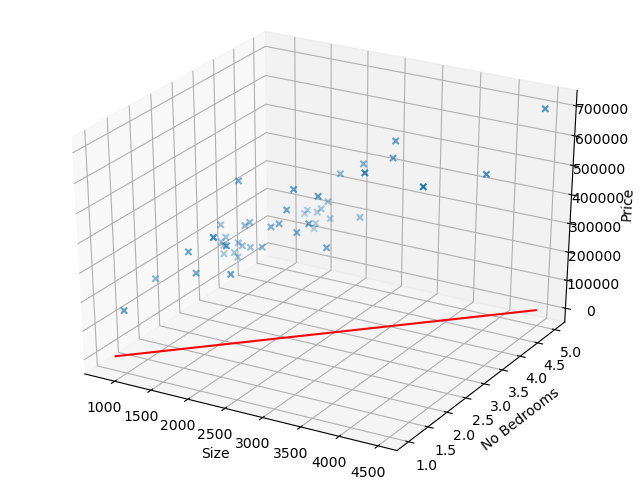

In [25]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(X[:, 0], X[:, 1], y, marker="x")
ax.set_xlabel('Size')
ax.set_ylabel('No Bedrooms')
ax.set_zlabel('Price')
plt.show()

As we can see each one of our parameters have different magnitudes, which leads to unnecessary steps in gradient descent. And not just that, in fact leaving the parameters as they are leads to integer overflows, so it is best to normalise them now.

In [26]:
X_normalised = (X - np.min(X, axis=0)) * (1/np.ptp(X, 0))
X_ones_normalised = np.column_stack((ones, X_normalised)).astype(np.float64)
y_normalised = (y - np.min(y, axis=0)) * (1/np.ptp(y, 0))

## Gradient Descent


We will start with realising that our output seems to depend on the input parameters linearly. Having made this assumptions we can now proceed to finding the best fit line to this dataset. We define the learning rate alpha, and the number of iterations. Furthermore, we initialise the parameters of the line.

In [27]:
theta = np.array([[1.], [1.], [1.]]).astype(np.float64)
iterations = 1000
alpha = 0.01

We can of course already check how well our line is doing, note that this is plotted in the same graph, above. 

In [28]:
x_axis = np.linspace(min(X[:,0]), max(X[:,0]), 100)
y_axis = np.linspace(1, 5, 100)
z_axis = theta[0] + theta[1]*x_axis + theta[2]*y_axis
ax.plot(x_axis, y_axis, z_axis, c="r")
plt.show()

So our line is not giving too good predictions. It would be nice however, to know exactly how far we are from the real data. We can define a cost function as follows:

$$J(\theta):\mathbb{R}^{n}\rightarrow \mathbb{R}^{n}$$
$$J(\theta) = \frac{1}{2m}\sum(\theta^TX - y)^2$$

Where $n$ is the number of features and the sum is taken over all the rows of $X$ column-wise. In Python this translates to:

In [29]:
def compute_cost(X, y, theta):
    return sum(np.square(np.dot(X, theta) - y)) / (2*len(X));

From this cost function, we can now get the direction of the steepest descent. We simply need to compute the partial derivatives of the cost function according to all the features. Using the power and chain rule, we get that the Jacobian of $J(\theta)$ is:

$$ J = \frac{1}{m} \sum(\theta^TX - y) \circ X $$

Where $\circ$ denotes element-wise multiplication. We can now define what a step of gradient descent should do, i.e. tweak $\theta$ by its derivate times the learning rate $alpha$. We save how the cost evolves over time and also return it for visualisation.

In [30]:
def gradient_descent(X, y, theta, iterations):
    cost_history = np.zeros((iterations, 1))
    for i in range(iterations):
        j_prime = (sum(np.multiply(np.dot(X, theta) - y, X)) / len(X))
        theta -= j_prime.reshape(theta.shape) * alpha
        
        cost_history[i][0] = compute_cost(X, y, theta)
    return [theta, cost_history]

In [31]:
theta, cost_history = gradient_descent(X_ones_normalised, y_normalised, theta, iterations)

Easiest way to check what happened is to plot how the cost changed over the iterations.

<IPython.core.display.Javascript object>


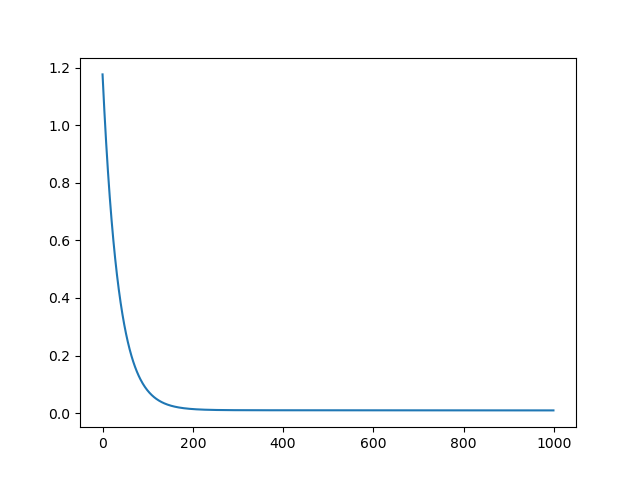

In [32]:
%matplotlib qt
plt.clf()
plt.cla()
plt.plot(cost_history)
plt.show()

Which seems quite something that we would want to see. We can also check how close our line is to the datapoints.

<IPython.core.display.Javascript object>


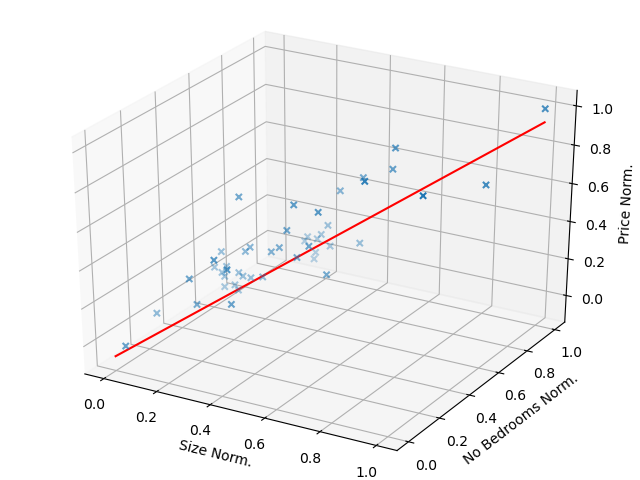

In [22]:
plt.clf()
plt.cla()
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(X_normalised[:, 0], X_normalised[:, 1], y_normalised, marker="x")
x_axis = np.linspace(min(X_normalised[:,0]), max(X_normalised[:,0]), 100)
y_axis = np.linspace(min(X_normalised[:,1]), max(X_normalised[:,1]), 100)
z_axis = theta[0] + theta[1]*x_axis + theta[2]*y_axis
ax.plot(x_axis, y_axis, z_axis, c="r")

ax.set_xlabel('Size Norm.')
ax.set_ylabel('No Bedrooms Norm.')
ax.set_zlabel('Price Norm.')
plt.show()

Which is great. This means that we can now make a prediction, say we have a flat of size 2000 units, but 2 bedrooms. Then:

In [34]:
prediction = theta[0] + theta[1] * 2000 + theta[2] * 2
print (prediction)

[1364.99047148]


Which is of course nonsense. This datapoint is well out of the range of our normalised dataset. We first need to scale it down also.

In [48]:
guess = np.array([2000, 2])
guess_normalised = (guess - np.min(X, axis=0)) * (1/np.ptp(X, 0))

prediction_normalised = theta[0] + theta[1] * guess_normalised[0] + theta[2] * guess_normalised[1]
prediction = prediction_normalised * (np.ptp(y, 0)) + np.min(y, axis=0)
print(prediction)

[289956.34790903]


Which sounds just a lot better.